# Postprocessing

Postprocessing generates a result table of achieved accuracies on the validation and test data and relates them to the model, corpus size, feature size and n-gram size used (see variable <code>results</code>).

- [Complete output of all tested models](#Complete-output-of-all-tested-models)

A detailed output of each model is also generated.

- [k nearest neighbors models](#k-nearest-neighbors-models)
- [Support vector models](#Support-vector-models)
- [Logistic regression models](#Logistic-regression-models)
- [Gradient boosting models](#Gradient-boosting-models)
- [Recurrent neural network models](#Recurrent-neural-network-models)

Furthermore, all variables that influence the performance of the machine learning models are plotted agains each other.

- [Model performance](#Model-performance)
- [Feature number performance](#Feature-number-performance)
- [Feature method performance](#Feature-method-performance)
- [n-gram performance](#n-gram-performance)


## Libraries

In [1]:
import re
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read validation data

Validation data is generated by the machine learning training and stored on the local file system in folders called <code>validation-</code> and followed by a model identifier (for example <code>log</code> for a logistic regression model). The files itself include the feature method (like <code>tf</code> for term frequency or <code>tf-idf</code> for term frequency inverse document frequency), the corpus size, the feature size and the n-gram size. This is then written as <code>tf-5000-500-1</code> for example, which means a term frequency method with a corpus size of 5000 and a feature size of 500 based on a unigram. The file further included both accuracies achieved during hyperparameter tuning based on the test data and the final accuracy achieved on the validation data.

In [2]:
def read_validation_directory():
    """
    Lists all validation directories on the local file system starting 
    with 'validation-' and followed by the model identifier.
    """
    available_content = os.listdir('.') 
    select_pattern = re.compile('^validation-[a-z][a-z][a-z]')
    selected_dir = [content for content in available_content if select_pattern.match(content)]
    return selected_dir

In [3]:
def read_validation_directory_content(validation_directories):
    """
    Reads the content from all files in the validation folders read by read_validation_directory().
    
    Args:
    - validation_directories (list of str): List of validation directories.
    
    Returns:
    - imported_data (pandas dataframe): Merged dataframe holding all the information from the files.
    """
    iteration = 0
    for directory in validation_directories:
        available_content = os.listdir(directory)
        for file in available_content:
            if iteration == 0:
                imported_data = pd.read_csv('{}/{}'.format(directory, file))
                imported_data['model'] = directory[11:]
            else:
                tmp_data = pd.read_csv('{}/{}'.format(directory, file)) 
                tmp_data['model'] = directory[11:] 
                imported_data = pd.concat([imported_data, tmp_data])
            iteration += 1
    
    imported_data.reset_index(drop=True, inplace=True)
    return imported_data

In [4]:
def text_split(x):
    """
    Performs a text split between '-' character.
    
    Args:
    - x (str): Text to be splitted.
    
    Returns:
    - y (list of str): List of splitted text.
    """ 
    y = x.split('-')
    return y

In [5]:
def extract_feature_information(df):
    """
    Convert the abbreviated information of feature method, corpus size, feature size and n-gram size to columns.
    
    Args:
    - df (pandas dataframe): Pandas dataframe to make the conversion on. The information to be splitted must be in 
    columnn 'data'.
    
    Returns:
    - df (pandas dataframe): Converted dataframe.
    """
    df_splitted = df['data'].apply(text_split)
    
    feature_method_list = []
    document_size_list = []
    feature_size_list = []
    ngram_size_list = []
    
    for splitted_entries in df_splitted:
        if splitted_entries[1] == 'idf': # inverse document frequency case
            feature_method_list.append('tf-idf')
            document_size_list.append(splitted_entries[2])
            feature_size_list.append(splitted_entries[3])
            ngram_size_list.append(splitted_entries[4])
        else:
            feature_method_list.append('tf')
            document_size_list.append(splitted_entries[1])
            feature_size_list.append(splitted_entries[2])
            ngram_size_list.append(splitted_entries[3])
    
    df['method'] = feature_method_list
    df['corpus'] = document_size_list
    df['feature'] = feature_size_list
    df['ngram'] = ngram_size_list
    df.drop(['data'], axis=1, inplace=True)
    
    # set index
    df.index = df['model'] + '-' + df['method'] + '-' + df['corpus'] + '-' + df['feature'] + '-' + df['ngram']
    
    return df

In [6]:
def to_percent(x):
    """
    Converts accuracy values (e.g. from 0.9633 to 96.33).
    
    Args:
    - x (float): Value to be converted.
    
    Returns:
    - y (float): Converted value.
    """
    y = round(x * 100, 2)
    return y

In [7]:
def read_results():
    """
    Read complete results of all tested models.
    """
    validation_directories = read_validation_directory()
    raw_results = read_validation_directory_content(validation_directories)
    results = extract_feature_information(raw_results)
    results.sort_values(by=['validation_accuracy'], ascending=False, inplace=True)
    results['validation_accuracy'] = to_percent(results['validation_accuracy'])
    results['test_accuracy'] = to_percent(results['test_accuracy'])
    return results

## Complete output of all tested models

The variable <code>results</code> contains all tested combinations of model, feature method, corpus size, feature size and n-gram size.

In [8]:
# read from all validation directories the accuracy and determine model settings
results = read_results()
results.head(results.shape[0]) # display all

,validation_accuracy,test_accuracy,model,method,corpus,feature,ngram
svc-tf-idf-5000-1000-1,97.36,96.02,svc,tf-idf,5000,1000,1
svc-tf-5000-5000-1,97.05,96.13,svc,tf,5000,5000,1
svc-tf-5000-1000-1,96.54,95.31,svc,tf,5000,1000,1
gbc-tf-5000-1000-1,96.34,96.02,gbc,tf,5000,1000,1
svc-tf-idf-5000-5000-1,96.03,95.21,svc,tf-idf,5000,5000,1
log-tf-idf-5000-5000-1,95.83,95.31,log,tf-idf,5000,5000,1
log-tf-idf-5000-1000-1,95.83,94.70,log,tf-idf,5000,1000,1
gbc-tf-5000-500-1,95.83,95.82,gbc,tf,5000,500,1
svc-tf-idf-5000-500-1,95.73,95.41,svc,tf-idf,5000,500,1
svc-tf-5000-500-1,95.42,95.11,svc,tf,5000,500,1


## Read tuned models

In order to see the hyperparameters for each model in detail for each setting, the following subchapters include this intersting information. The model details are stored in a folder on the file system beginning with <code>tuned-model-</code> followed again by a model identifier. In the file, the model parameters that produce the best accuracy on the test data are stored (after hyperparameter tuning).

In [9]:
def read_tuned_model_directory_content(prefix):
    """
    Low level file reader that converts content into pandas dataframe.
    
    Args:
    - prefix (str): Denoting the identifier for the machine learning model.
    
    Returns:
    - imported_data (pandas dataframe): Imported pandas dataframe.
    """
    path = 'tuned-model-{}'.format(prefix)
    available_content = os.listdir(path)
    iteration = 0
    for file in available_content:
        if iteration == 0:
            imported_data = pd.read_csv('{}/{}'.format(path, file))
            imported_data['model'] = prefix
        else:
            tmp_data = pd.read_csv('{}/{}'.format(path, file)) 
            tmp_data['model'] = prefix
            imported_data = pd.concat([imported_data, tmp_data])
        iteration += 1   
            
    imported_data.reset_index(drop=True, inplace=True)
    
    return imported_data    

In [10]:
def read_tuned_model_results(prefix):
    """
    Reads the tuned model results from hyperparameter tuning.
    
    Args:
    - prefix (str): Denoting the identifier for the machine learning model.
    
    Returns:
    - results (pandas dataframe): Resulting hyperparameters.
    """
    raw_results = read_tuned_model_directory_content(prefix)
    results = extract_feature_information(raw_results)
    
    return results

In [11]:
def join_with_accuracy(tuned_model_results, accuracy_results):
    """
    Joins (inner) the detailed model results and the general output of all model results together based on the index.
    
    Args:
    - tuned_model_results (pandas dataframe): Dataframe holding the tuned model results 
    (obtained from function read_tuned_model_results()).
    - accuracy_results (pandas dataframe): Dataframe holding the complete accuracy results of all models and influential
    variables.
    
    Returns:
    - tuned_model_results (pandas dataframe): Dataframe containing the join of both tables. 
    """
    # remove features present in both dataframes
    accuracy_drop = accuracy_results.drop(['model', 'method', 'corpus', 'feature', 'ngram'], axis=1)
    
    tuned_model_results = tuned_model_results.join(accuracy_drop, how='inner')
    tuned_model_results.sort_values(by=['validation_accuracy'], ascending=False, inplace=True)
    tuned_model_results.reset_index(drop=True, inplace=True)
    
    return tuned_model_results

## k nearest neighbors models

In [12]:
results_knn = read_tuned_model_results('knn')
results_knn = join_with_accuracy(results_knn, results)
results_knn.head(results_knn.shape[0]) # display all

,p,weights,n_neighbors,model,method,corpus,feature,ngram,validation_accuracy,test_accuracy
0,1,uniform,13,knn,tf-idf,5000,1000,1,92.07,92.25
1,1,uniform,13,knn,tf,5000,1000,1,91.56,92.66
2,1,distance,8,knn,tf,5000,500,1,91.15,92.35
3,1,distance,12,knn,tf-idf,5000,500,1,90.74,91.95
4,1,uniform,15,knn,tf,5000,5000,1,89.83,91.13
5,6,distance,4,knn,tf,5000,1000,2,79.45,81.35
6,1,distance,6,knn,tf-idf,5000,5000,1,79.25,79.41
7,7,distance,7,knn,tf,5000,500,2,79.25,81.24
8,6,distance,3,knn,tf,5000,5000,2,79.04,80.84
9,8,distance,3,knn,tf-idf,5000,1000,2,78.03,78.90


## Support vector models

In [13]:
results_svc = read_tuned_model_results('svc')
results_svc = join_with_accuracy(results_svc, results)
results_svc.head(results_svc.shape[0]) # display all

,random_state,degree,kernel,C,model,method,corpus,feature,ngram,validation_accuracy,test_accuracy
0,1,2,poly,2.953042,svc,tf-idf,5000,1000,1,97.36,96.02
1,1,2,poly,2.815403,svc,tf,5000,5000,1,97.05,96.13
2,1,2,poly,1.097294,svc,tf,5000,1000,1,96.54,95.31
3,1,2,poly,3.000000,svc,tf-idf,5000,5000,1,96.03,95.21
4,1,2,poly,2.811214,svc,tf-idf,5000,500,1,95.73,95.41
5,1,2,poly,3.000000,svc,tf,5000,500,1,95.42,95.11
6,1,2,poly,3.000000,svc,tf,5000,500,2,90.13,88.58
7,1,2,poly,2.839080,svc,tf,5000,1000,2,89.73,90.01
8,1,2,poly,2.449617,svc,tf-idf,5000,1000,2,89.22,89.40
9,1,2,poly,2.973663,svc,tf-idf,5000,5000,2,89.11,88.48


## Logistic regression models

In [14]:
results_log = read_tuned_model_results('log')
results_log = join_with_accuracy(results_log, results)
results_log.head(results_log.shape[0]) # display all

,C,max_iter,model,method,corpus,feature,ngram,validation_accuracy,test_accuracy
0,2.489134,10000,log,tf-idf,5000,5000,1,95.83,95.31
1,2.994826,10000,log,tf-idf,5000,1000,1,95.83,94.70
2,0.973165,10000,log,tf-idf,5000,5000,2,95.12,94.90
3,2.570000,10000,log,tf-idf,5000,500,1,95.02,93.78
4,2.264352,10000,log,tf-idf,5000,1000,2,93.59,93.48
5,2.992811,10000,log,tf,5000,500,1,93.18,91.95
6,2.756580,10000,log,tf,5000,5000,1,93.18,92.25
7,2.785545,10000,log,tf,5000,1000,1,92.98,91.85
8,0.340278,10000,log,tf-idf,5000,500,2,92.17,92.86
9,2.785293,10000,log,tf,5000,500,2,91.56,91.74


## Gradient boosting models

In [15]:
results_gbc = read_tuned_model_results('gbc')
results_gbc = join_with_accuracy(results_gbc, results)
results_gbc.head(results_gbc.shape[0]) # display all

,max_depth,random_state,n_estimators,learning_rate,model,method,corpus,feature,ngram,validation_accuracy,test_accuracy
0,4,1,874,0.439655,gbc,tf,5000,1000,1,96.34,96.02
1,9,1,379,0.494486,gbc,tf,5000,500,1,95.83,95.82
2,6,1,305,0.193222,gbc,tf-idf,5000,500,1,95.42,95.92


## Recurrent neural network models

In [16]:
#results_mlp = read_tuned_model_results('mlp')
#results_mlp = join_with_accuracy(results_mlp, results)
#results_mlp.head(results_mlp.shape[0]) # display all

## Performance in detail

We see here detailed boxplots about the features that influcence machine learning model training. We take all variations of feature method, feature size and n-gram size into account to make some general recommendations.

In [17]:
def evaluate_average_performance(df, group_variable):
    """
    Performs a mean calculation on the accuracy based on a grouped variable.
    
    Args:
    - df (pandas dataframe): Dataframe to perform the grouping on.
    - group_variable (str): Variable denoting the feature we will group on.
    
    Returns:
    - performance (pandas dataframe): Grouped dataframe.
    """
    performance = df[['validation_accuracy', group_variable]].groupby([group_variable]).mean()
    performance.sort_values(by=['validation_accuracy'], ascending=False, inplace=True)
    return performance

In [18]:
def create_boxplot(df, x, y, path, output):
    """
    Create boxplot.
    
    Args:
    - x (list of str): Represents the classes on the x-axis.
    - y (list of float): Represents the accuracy values on the y-axis.
    - path (str): Output folder.
    - output (str): Output file name.
    
    Returns:
    - none: Saves a figure in the end on the file system {path}/{output}.
    """
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    %matplotlib inline
    
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x=x, y=y, data=df, palette='Set1') 
    
    fig.savefig('{}/{}'.format(path, output))

## Model performance

Influence of the machine learning model on the validation accuracy.

In [19]:
model_performance = evaluate_average_performance(results, 'model')
model_performance

,validation_accuracy
model,
gbc,95.863333
log,93.446667
svc,92.743333
knn,83.640000


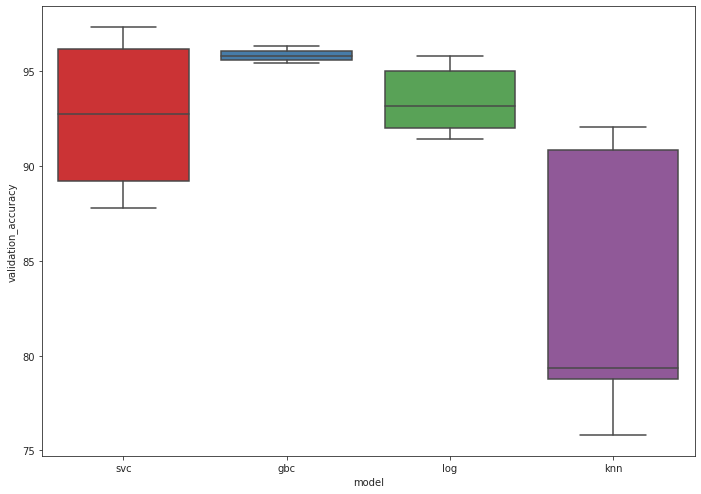

In [20]:
create_boxplot(results, 'model', 'validation_accuracy', 'output', 'model_performance.png')

## Feature number performance

Influence of the feature size on the validation accuracy.

In [21]:
feature_performance = evaluate_average_performance(results, 'feature')
feature_performance

,validation_accuracy
feature,
1000,91.088462
500,90.852143
5000,89.122500


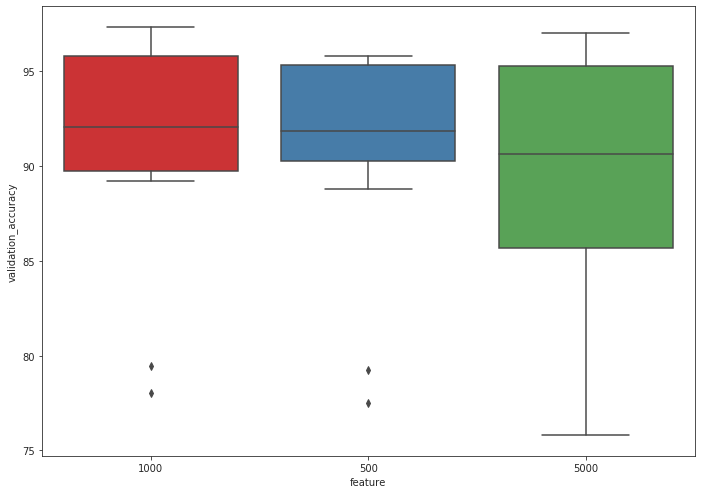

In [22]:
create_boxplot(results, 'feature', 'validation_accuracy', 'output', 'feature_performance.png')

## Feature method performance

Influence of the feature method on the validation accuracy.

In [23]:
method_performance = evaluate_average_performance(results, 'method')
method_performance

,validation_accuracy
method,
tf,90.645500
tf-idf,90.138947


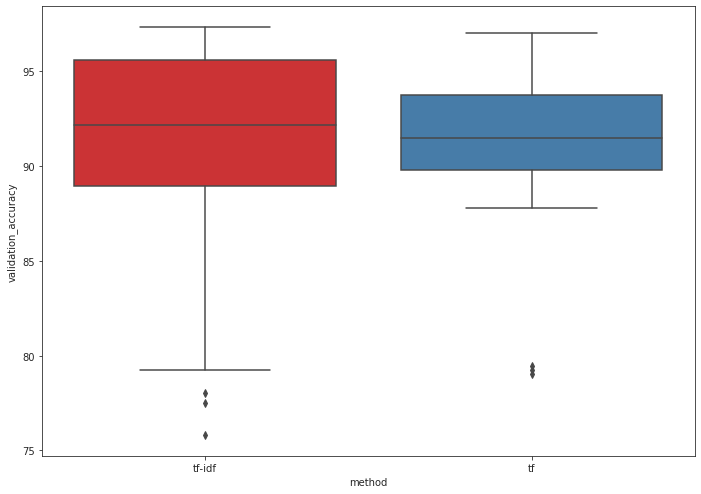

In [24]:
create_boxplot(results, 'method', 'validation_accuracy', 'output', 'method_performance.png')

## n-gram performance

Influence of the n-gram size on the validation accuracy.

In [25]:
ngram_performance = evaluate_average_performance(results, 'ngram')
ngram_performance

,validation_accuracy
ngram,
1,93.635238
2,86.622778


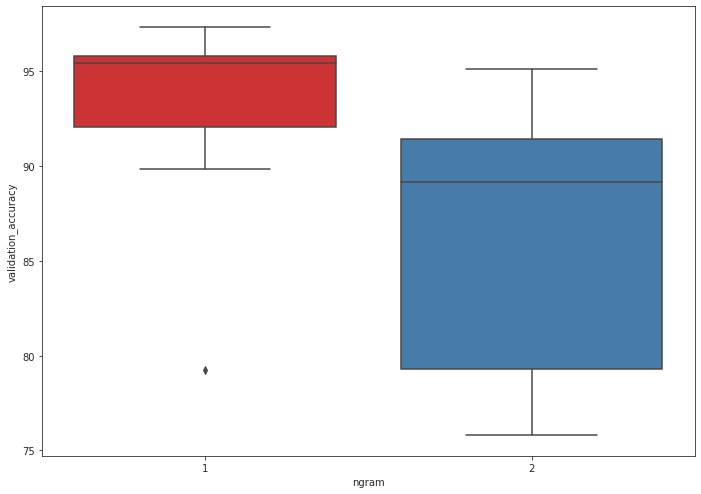

In [26]:
create_boxplot(results, 'ngram', 'validation_accuracy', 'output', 'ngram_performance.png')